In [93]:
from librosa import load, ex, feature, display
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt

In [30]:
def segment_signal(signal, winDur = 20e-3, hopDur=10e-3, sr=16e3):
    # hop_size in ms
    winLen = int(winDur*sr)
    hopLen = int(hopDur*sr)
    signal = np.pad(signal, winLen//2, mode='reflect')

    nframes = int((len(signal) - winLen) / hopLen) + 1
    frames = np.zeros((nframes,winLen))
    
    window = np.hamming(winLen)
    window = window-np.min(window)
    window = window/np.max(window)

    for n in range(nframes):
        frames[n] = window*signal[n*hopLen:n*hopLen+winLen]
    return frames

In [31]:
def nearestpow2(n):
    k=1
    while n>2**k:
        k = k+1
    return 2**k

In [32]:
def freq_to_mel(freq):
    # converting linear scale frequency to mel-scale
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def mel_to_freq(mels):
    # converting mel-scale frequency to linear scale
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [33]:
def get_filter_points(fmin, fmax, mel_filter_num, nfft, sample_rate=16000):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)

    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = mel_to_freq(mels)

    return np.floor((nfft) / sample_rate * freqs).astype(int), freqs

def get_filters(filter_points, nfft):
    filters = np.zeros((len(filter_points)-2,int(nfft/2+1)))

    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])

    return filters

In [149]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)

    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)

    return basis

dct_basis = dct(40,40)

In [45]:
y, sr = load(ex('libri1'))
hopDur = 10e-3 #ms
winDur = 20e-3

In [46]:
x_segs_hamming = segment_signal(y, winDur=winDur, hopDur= hopDur, sr=sr)

In [133]:
#collapse
x_segs = x_segs_hamming.copy()
nfft = nearestpow2(x_segs_hamming.shape[1])
X = np.zeros((x_segs.shape[0],int(nfft/2)+1))
X_fft = np.fft.rfft(x_segs,nfft,axis=1) # fft block verwenden
X = np.abs(X_fft)**2

In [142]:
freq_min = 0
freq_high = sr / 2
mel_filter_num = 40

filter_points, freqs = get_filter_points(freq_min, freq_high, mel_filter_num, nfft=nfft, sample_rate=sr)
filters = get_filters(filter_points, nfft=nfft)

In [143]:
X_filtered = np.dot(filters, X.T)
X_filtered_log = 10.0 * np.log10(X_filtered)

X = np.where(X == 0,np.finfo(float).eps, X)

In [150]:
dct_filter_num = X_scaled.shape[0]
dct_filters = dct(dct_filter_num, X_filtered_log.shape[0])
cepstral_coefficents = np.dot(dct_filters, X_filtered_log)

In [145]:
mfccs = feature.mfcc(y=y, sr=sr, n_mfcc=40)
mfccs

array([[-565.9195   , -564.28815  , -562.8431   , ..., -437.97177  ,
        -426.48358  , -434.66782  ],
       [  10.304618 ,   12.508709 ,   14.130636 , ...,   89.98184  ,
          88.43012  ,   90.120255 ],
       [   9.748487 ,   11.672071 ,   12.139029 , ...,  -10.730869 ,
         -10.773369 ,   -5.2245703],
       ...,
       [  -1.5704863,   -2.0978153,   -3.0435863, ...,   -2.585959 ,
          -4.4007945,   -4.668362 ],
       [  -1.9920207,   -2.682422 ,   -3.1783807, ...,   -4.045431 ,
           1.487895 ,    3.6362567],
       [  -2.1463804,   -2.8828554,   -2.8759928, ...,    1.6753986,
           3.1740243,    2.8180344]], dtype=float32)

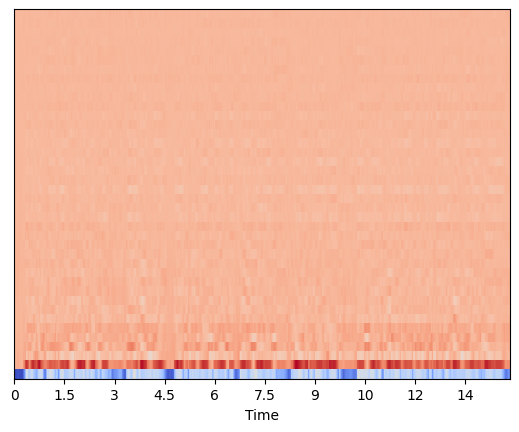

In [146]:
display.specshow(mfccs, x_axis='time')

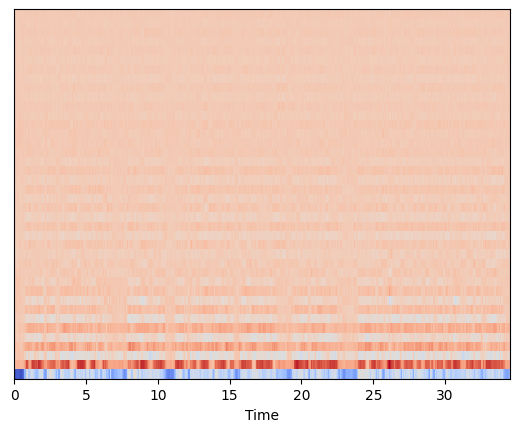

In [147]:
display.specshow(cepstral_coefficents, x_axis='time')